### Laboratorium 6 - Znajdowanie obszarów podobnych poprzez parowanie punktów kluczowych

#### Parowanie punktów kluczowych - podstawy

Jednym z typowych zadań związanych z przetwarzaniem obrazów jest odnajdowanie obszarów podobnych między dwoma obrazami (choć nic nie stoi na przeszkodzie, by poszukiwać samo-podobieństw w obrębie jednego obrazu - narzędzia omówione w tej instrukcji również się do tego celu nadadzą). Do tego problemu redukują się zadania takie jak wyszukiwanie wystąpień danego wzorca (_mam obraz jakiegoś obiektu oraz obraz sceny zawierającej różne obiekty: gdzie znajduje się dany obiekt?_) czy łączenie wielu obrazów zawierających części wspólne (tzw. *image stitching*).

Podejście składa się z dwóch kroków: wykrycia punktów zainteresowania na obu obrazach, oraz *sparowania* podobnych do siebie punktów z obu obrazów (ang. *keypoint matching*). Parowania dokonuje się względem pewnego opisu punktu kluczowego, tj. *deskryptora* obliczonego dla rejonu otaczającego dany punkt. Idea za tym procesem stoi taka, że punkty, których deskryptory są w jakimś sensie do siebie "podobne", prawdopodobnie reprezentują podobne obszary na obrazie.

Oczywiście, różne algorytmy detekcji (SIFT, SURF, ORB, BRIEF, [LoFTR](https://zju3dv.github.io/loftr/), ...) obliczają deskryptory na różne sposoby - głównym rozróżnieniem jest tu forma deskryptora: detektory takie jak SIFT czy SURF zwracają deskryptory w formie liczb zmiennoprzecinkowych, a ORB czy BRIEF w formie binarnej. Jest to o tyle ważne, że wpływa to na dobór miary podobieństwa między deskryptorami. Dla deskryptorów ciągłych przyjmuje się najczęściej miary $L^1$ lub $L^2$, dla binarnych - odległość Hamminga. Warto podkreślić, że położenie punktów kluczowych w przestrzeni obrazu jest na tym etapie pomijane.

Proces parowania, pomijając obliczeniowe optymalizacje, przebiega w następujący sposób:
* dla każdego punktu kluczowego $P_i$ z obrazu A (często nazywanego też *train*),
* znajdź punkt kluczowy $Q_j$ z obrazu B (*query*) taki, że odległość $L(P_i, Q_j)$ jest najmniejsza.

Naturalnie, oznacza to że *zawsze* znajdziemy pewne dopasowanie - lepsze lub gorsze. Z tego powodu implementacje matcherów w OpenCV zwracają wyniki dopasowania w bogatej formie, informując od razu o wyliczonych dystansach (w przestrzeni cech) między punktami. Dzięki temu możemy prowadzić dalsze przetwarzanie wyników, uwzględniając np. tylko pary o dystansie poniżej pewnego ustalonego progu.

Czasami przydatne jest odnalezienie $k$ najlepszych dopasowań, tj. $k$ punktów z obrazu B o deskryptorach najbliższych danemu punktowi z obrazu A. Możemy w ten sposób wykryć np. wiele wystąpień szukanego wzorca. Podejście to może też posłużyć do wnioskowania o *pewności* parowania - jeśli spodziewamy się, że dla podanego punktu $\hat{P_i}$ powinien znaleźć się tylko jeden silny odpowiednik $\hat{Q_j}$, tj. $L(\hat{P_i},\hat{Q_j})$ będzie bardzo niskie, ale dla pozostałych $Q$ wysokie, a tymczasem odległości pomiędzy  najbliższymi kandydatami są porównywalne, to prawdopodobnie nie jest to dobre dopasowanie [1].

#### Uwzględnianie relacji geometrycznych

Powyższe dotyczy jedynie parowania *pojedynczych* punktów kluczowych, co samo w sobie stanowi z reguły tylko podstawę dalszego przetwarzania. Jak już bowiem powiedzieliśmy, parowanie zawsze zwraca jakieś wyniki, prawdopodobnie bardzo liczne (jeśli na etapie detekcji wykryta została duża liczba punktów kluczowych), niemal z pewnością zawierające dużą liczbę dopasowań fałszywych. Powiedzieliśmy również, że proces ten pomija informację o geometrycznym położeniu punktów - co oczywiste, ponieważ wiemy że odpowiadające sobie punkty leżą w nieznanych obszarach obrazów. Wiemy natomiast (albo: robimy takie założenie a priori), że *pewien podzbiór* punktów interesujących obrazu A cechuje się jakąś wewnętrzną geometrią, a więc: jeśli obiekt, któremu ten podzbiór odpowiada, znajduje się na obrazie B, to pewien zbiór punktów obrazu B będzie również cechował się zbliżoną geometrią. Odnalezienie odpowiadających sobie zbiorów punktów jest nietrywialne z przynajmniej trzech powodów:
* między obrazami A i B zachodzi pewna transformacja geometryczna (np. afiniczna lub perspektywiczna),
* nie wszystkie punkty z interesującego podzbioru w A mogły zostać wykryte w B,
* detekcja punktów może cechować się zakłóceniami w dziedzinie zarówno geometrycznej jak i przestrzeni desktryptora.

Aby opisać transformację jednego obrazu w drugi, potrzebujemy znaleźć pewną macierz przekształcenia $\mathbf{M}$. Pomińmy na razie jej specyfikę - czy będzie to transformacja afiniczna czy perspektywiczna, czy we współrzędnych zwykłych czy jednorodnych. Znamy sposoby, aby znaleźć tę macierz, mając listę punktów wejściowych i ich przekształcone odpowiedniki: jeśli dysponujemy dokładnie trzema punktami, możemy wyliczyć parametry macierzy transformacji afinicznej (czterema dla perspektywy), jeśli mamy ich więcej (prawie zawsze), możemy skorzystać z metody np. najmniejszych kwadratów do zoptymalizowania jej parametrów. Metoda ta jednak jest bardzo podatna na obecność outlierów - nawet pojedyncze źle dopasowane punkty zniekształcą otrzymane parametry przekształcenia; typowy przypadek użycia jest jeszcze trudniejszy: tylko niewielki procent wszystkich punktów może być "dobrze" dopasowany. W tej sytuacji najczęściej korzysta się z algorytmów klasy Random Sample Consensus (RANSAC bądź jego liczne ulepszenia, np. USAC), polegających na iteracyjnym dopasowywaniu **podzbioru** punktów do modelu - tj. naprzemian dopasowujemy parametry przekształcenia na podstawie pewnej próbki, a następnie poprawiamy dobór tej próbki, tak by ostatecznie uzyskać dopasowanie bardzo dobrze opisujące tylko pewien podzbiór danych.

W efekcie takiej procedury (jeśli się powiodła) otrzymujemy macierz opisującą przekształcenie geometryczne, które transformuje pewien obszar obrazu A (zawierający pewien dobrze określony podzbiór punktów zainteresowania) w pewien obszar obrazu B (zawierający punkty odpowiadające tamtym). Mamy zatem wszystkie informacje opisujące dwa podobne obszary obrazów. $\blacksquare$

#### Matchowanie - przykład

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rotate(image, angle, scale=1.0):
    center = (image.shape[0] // 2, image.shape[1] // 2)
    rmat = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rmat, (image.shape[0], image.shape[1]), flags=cv2.INTER_CUBIC)

Zacznijmy od znanej nam Leny, traktując ją jako obraz A ("train").

In [5]:
lena = cv2.imread('Lena.jpg')

Jako "query" weźmy lekko zniekształconą wersję obrazu.

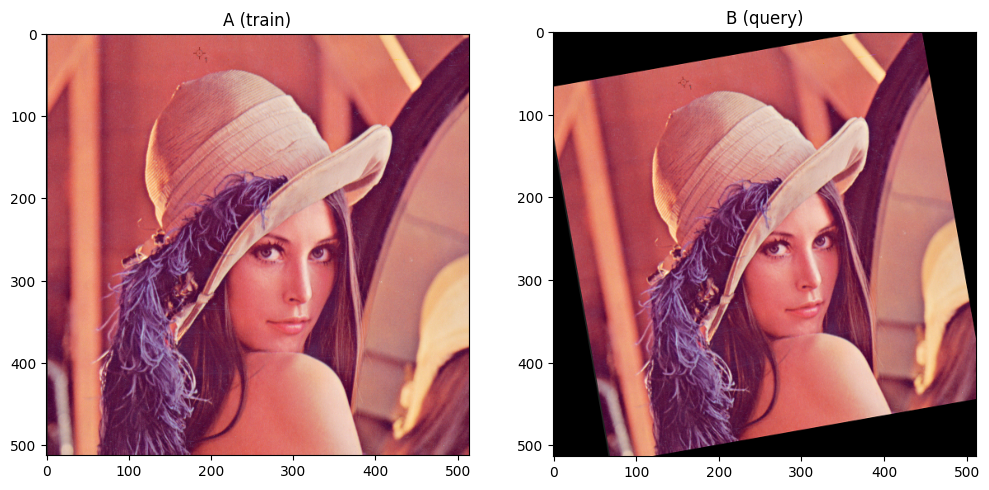

In [6]:
query = rotate(lena, 10, 0.9)
f, (a1, a2) = plt.subplots(1,2,figsize=(12,12))
a1.imshow(lena[..., ::-1]);
a1.set_title('A (train)');
a2.imshow(query[..., ::-1]);
a2.set_title('B (query)');

Przeprowadźmy standardową detekcję punktów kluczowych za pomocą SIFT:

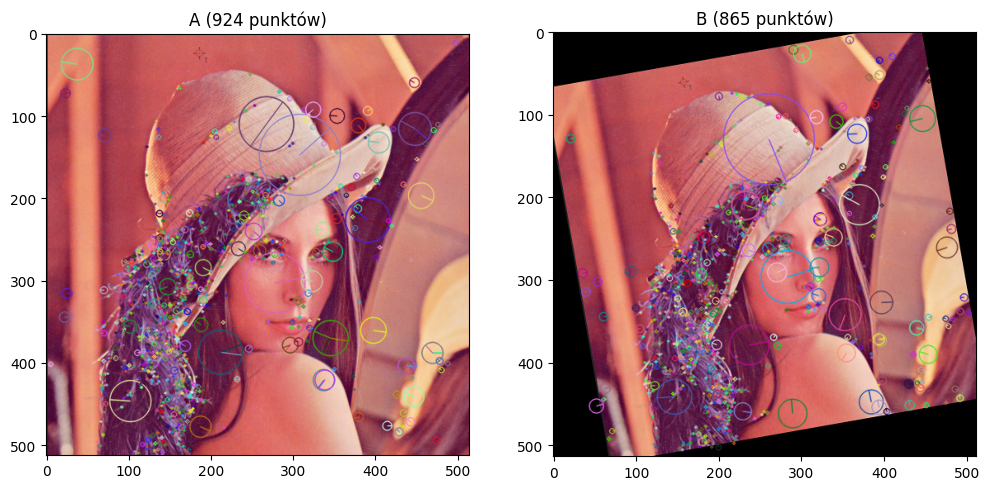

In [7]:
sift = cv2.SIFT_create(contrastThreshold=0.05)
kp1, ds1 = sift.detectAndCompute(lena, mask=None)
kp2, ds2 = sift.detectAndCompute(query, mask=None)
f, (a1, a2) = plt.subplots(1,2,figsize=(12,12))
d_lena = cv2.drawKeypoints(lena, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
d_query = cv2.drawKeypoints(query, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
a1.imshow(d_lena[..., ::-1]);
a1.set_title('A ({} punktów)'.format(len(kp1)));
a2.imshow(d_query[..., ::-1]);
a2.set_title('B ({} punktów)'.format(len(kp2)));

Dopasowywanie punktów kluczowych odbywa się, podobnie jak detekcja, za pomocą specjalnego obiektu klasy [`cv::DescriptorMatcher`](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html). Można go w OpenCV stworzyć na co najmniej dwa sposoby: albo używając funkcji [`cv2.DescriptorMatcher_create`](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#ab5dc5036569ecc8d47565007fa518257), która przyjmuje typ matchera jako flagę:
* `cv2.DESCRIPTOR_MATCHER_BRUTEFORCE` (oraz [pochodne](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#af8b6f4acb8f1a9ea6b73bfcb86b80c3b)) tworzy zwykły matcher sprawdzający każdy-z-każdym,
* `cv2.DESCRIPTOR_MATCHER_FLANNBASED` tworzy matcher wykorzystujący bibliotekę FLANN (Fast Library for Approximate Nearest Neighbors) do przyspieszonego wyszukiwania.

Alternatywnie, można tworzyć obiekty ręcznie: `cv2.BFMatcher_create` lub `cv2.FlannBasedMatcher_create` - różnica jest tylko w sposobie przekazywania argumentów, np. do konfiguracji akceleratora FLANN.

In [8]:
matcher = cv2.BFMatcher_create()

Wyszukiwanie możemy zrobić również na dwa sposoby, i tutaj różnica jest bardziej znacząca, gdyż otrzymamy wyniki subtelnie różniące się formatem:
* [`DescriptorMatcher.match()`](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba) wykonuje proste matchowanie 1-1 i zwraca dopasowania jako listę specjalnych obiektów `cv2.DMatch` (każdy odpowiada jednemu punktowi ze zbioru *query*),
* [`DescriptorMatcher.knnMatch()`](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89) wykonuje matchowanie k-najlepszych kandydatów, zwracając dopasowania jako listę zawierającą listy (każda odpowiada jednemu punktowi z *query*) obiektów `cv2.DMatch` (każdy odpowiada jednemu z k najbliższych).

In [9]:
best_matches = matcher.match(ds1, ds2)
print(len(best_matches), type(best_matches[0]))

924 <class 'cv2.DMatch'>


In [10]:
best_k_matches = matcher.knnMatch(ds1, ds2, k=3)
print(len(best_k_matches), len(best_k_matches[0]), type(best_k_matches[0][0]))

924 3 <class 'cv2.DMatch'>


Obiekt `cv2.DMatch` zawiera wszystkie informacje o dopasowanych punktach, dystansie między nimi itp.:

In [11]:
print('Punkty {} i {}, odległość = {:.3f}'.format(
    best_matches[0].queryIdx,
    best_matches[0].trainIdx,
    best_matches[0].distance
))

Punkty 0 i 852, odległość = 235.230


Do prezentacji wyników najczęściej używa się funkcji [`cv2.drawMatches`](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a) i `cv2.drawMatchesKnn` - ta druga ma identyczny interfejs, ale przyjmuje argument `matches1to2` w postaci listy list k najlepszych. Zwróć uwagę na różne dostępne [flagi](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a) sterujące rysowaniem.

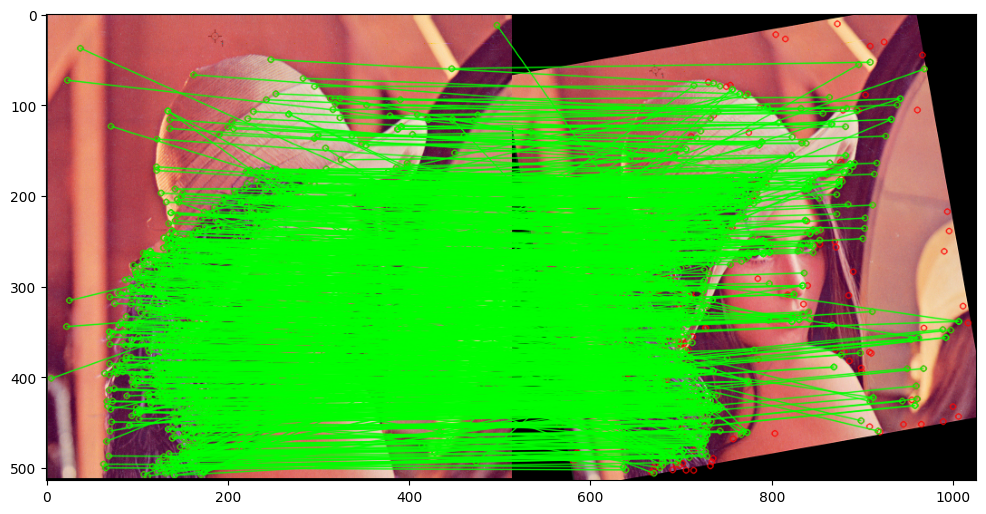

In [12]:
show_matches = cv2.drawMatches(lena, kp1, query, kp2, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1]);

#### Znajdowanie przekształceń geometrycznych

OpenCV zawiera cały pakiet funkcji związanych z przekształceniami geometrycznymi - calib3d. Dla nas najbardziej interesująca będzie [`cv2.findHomography`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780), służąca do znajdowania macierzy homografii (perspektywy) przekształcającej jeden obraz w drugi. Funkcja przyjmuje dwa zbiory punktów (surowe/przekształcone) w formie `ndarray` typu float32/float64 i wymiaru Nx2 oraz flagę kodującą metodę (plus argumenty opcjonalne) i zwraca znalezioną macierz transformacji 3x3 (albo `None`).

Oprócz tego, przydadzą Ci się:
* [`cv2.warpPerspective`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) - do przekształcania całego obrazu zgodnie ze znalezioną macierzą
* [`cv2.perspectiveTransform`](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gad327659ac03e5fd6894b90025e6900a7) - do przekształcania zestawu punktów zgodnie ze znalezioną macierzą (co, rzecz jasna, można łatwo zrobić ręcznie w numpy, korzystając ze współrzędnych jednorodnych)

#### Literatura

[1] - Lowe, *Distinctive Image Features from Scale-Invariant Keypoints*, 2004 ([LINK](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf))